# Visualizing JIT Modules

Copyright 2020 by Thomas Viehmann

This is the code for my blog post [Visualize PyTorch models](https://lernapparat.de/visualize-pytorch-models/).
The code has been made available thanks to my [single github sponsor](https://github.com/sponsors/t-vi/) at the time of writing. Thank you!

I license this code with the CC-BY-SA 4.0 license. Please link to my blog post or the original github source (linked from the blog post) with the attribution notice.


## Introduction

Did you ever wish to get a concise picture of your PyTorch model's structure and found that too hard to get?


Recently, I did some work that involved looking at model structure in some detail. For my write-up, I wanted to get a diagram of some model structures. Even though it is a relatively common model, searching for a diagram didn't turn up something in the shape what I was looking for.

So how do can we get model structure for PyTorch models? The first stop probably is the neat string representation that PyTorch provides for `nn.Modules` - even without doing anything, it'll also cover our custom models pretty well. It is, however not without shortcomings.

Let's look at TorchVision's ResNet18 basic block as an example.

In [1]:
import torchvision
m = torchvision.models.resnet18()
m.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

So we have two convs and two batch norms. But how are things connected? Is there one ReLU?

Looking at the forward method (you can get this using Python's `inspect` module or `??` in IPython), we see some important details not in the summary:

In [3]:
import inspect
print(inspect.getsource(m.layer1[0].forward))

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



So we missed the entire residual bit. Also, there are two ReLUs. Arguably, it is wrong to re-use stateless modules like this. It'll haunt you when you do things like quantization (because it becomes stateful then due to the quantization parameters) and it's mixing things too much. If you want stateless, use the functional interface.

But so we can build a visualization based on JITed modules.

We recurse into calls to make subgraphs and we have to take some care that the edges connecting the subgraph to the outer graph need to be part of the outer graph, but other than that, it is very straightforward, even though the details are messy.

In [1]:
import graphviz

def make_graph(mod, classes_to_visit=None, classes_found=None, dot=None, prefix="",
               input_preds=None, 
               parent_dot=None):
    preds = {}
    
    def find_name(i, self_input, suffix=None):
        if i == self_input:
            return suffix
        cur = i.node().s("name")
        if suffix is not None:
            cur = cur + '.' + suffix
        of = next(i.node().inputs())
        return find_name(of, self_input, suffix=cur)

    gr = mod.graph
    toshow = []
    # list(traced_model.graph.nodes())[0]
    self_input = next(gr.inputs())
    self_type = self_input.type().str().split('.')[-1]
    preds[self_input] = (set(), set()) # inps, ops
    
    if dot is None:
        dot = graphviz.Digraph(format='svg', graph_attr={'label': self_type, 'labelloc': 't'})
        #dot.attr('node', shape='box')

    seen_inpnames = set()
    seen_edges = set()
    
    def add_edge(dot, n1, n2):
        if (n1, n2) not in seen_edges:
            seen_edges.add((n1, n2))
            dot.edge(n1, n2)

    def make_edges(pr, inpname, name, op, edge_dot=dot):
        if op:
            if inpname not in seen_inpnames:
                seen_inpnames.add(inpname)
                label_lines = [[]]
                line_len = 0
                for w in op:
                    if line_len >= 20:
                        label_lines.append([])
                        line_len = 0
                    label_lines[-1].append(w)
                    line_len += len(w) + 1
                edge_dot.node(inpname, label='\n'.join([' '.join(w) for w in label_lines]), shape='box', style='rounded')
                for p in pr:
                    add_edge(edge_dot, p, inpname)
            add_edge(edge_dot, inpname, name)
        else:
            for p in pr:
                add_edge(edge_dot, p, name)

    for nr, i in enumerate(list(gr.inputs())[1:]):
        name = prefix+'inp_'+i.debugName()
        preds[i] = {name}, set()
        dot.node(name, shape='ellipse')
        if input_preds is not None:
            pr, op = input_preds[nr]
            make_edges(pr, 'inp_'+name, name, op, edge_dot=parent_dot)
        
    def is_relevant_type(t):
        kind = t.kind()
        if kind == 'TensorType':
            return True
        if kind in ('ListType', 'OptionalType'):
            return is_relevant_type(t.getElementType())
        if kind == 'TupleType':
            return any([is_relevant_type(tt) for tt in t.elements()])
        return False

    for n in gr.nodes():
        only_first_ops = {'aten::expand_as'}
        rel_inp_end = 1 if n.kind() in only_first_ops else None
            
        relevant_inputs = [i for i in list(n.inputs())[:rel_inp_end] if is_relevant_type(i.type())]
        relevant_outputs = [o for o in n.outputs() if is_relevant_type(o.type())]
        if n.kind() == 'prim::CallMethod':
            fq_submodule_name = '.'.join([nc for nc in list(n.inputs())[0].type().str().split('.') if not nc.startswith('__')])
            submodule_type = list(n.inputs())[0].type().str().split('.')[-1]
            submodule_name = find_name(list(n.inputs())[0], self_input)
            name = prefix+'.'+n.output().debugName()
            label = prefix+submodule_name+' (' + submodule_type + ')'
            if classes_found is not None:
                classes_found.add(fq_submodule_name)
            if ((classes_to_visit is None and
                 (not fq_submodule_name.startswith('torch.nn') or 
                  fq_submodule_name.startswith('torch.nn.modules.container')))
                or (classes_to_visit is not None and 
                    (submodule_type in classes_to_visit
                    or fq_submodule_name in classes_to_visit))):
                # go into subgraph
                sub_prefix = prefix+submodule_name+'.'
                with dot.subgraph(name="cluster_"+name) as sub_dot:
                    sub_dot.attr(label=label)
                    submod = mod
                    for k in  submodule_name.split('.'):
                        submod = getattr(submod, k)
                    make_graph(submod, dot=sub_dot, prefix=sub_prefix,
                              input_preds = [preds[i] for i in list(n.inputs())[1:]],
                              parent_dot=dot, classes_to_visit=classes_to_visit,
                              classes_found=classes_found)
                for i, o in enumerate(n.outputs()):
                    preds[o] = {sub_prefix+f'out_{i}'}, set()
            else:
                dot.node(name, label=label, shape='box')
                for i in relevant_inputs:
                    pr, op = preds[i]
                    make_edges(pr, prefix+i.debugName(), name, op)
                for o in n.outputs():
                    preds[o] = {name}, set()
        elif n.kind() == 'prim::CallFunction':
            funcname = list(n.inputs())[0].type().__repr__().split('.')[-1]
            name = prefix+'.'+n.output().debugName()
            label = funcname
            dot.node(name, label=label, shape='box')
            for i in relevant_inputs:
                pr, op = preds[i]
                make_edges(pr, prefix+i.debugName(), name, op)
            for o in n.outputs():
                preds[o] = {name}, set()
        else:
            unseen_ops = {'prim::ListConstruct', 'prim::TupleConstruct', 'aten::index', 
                          'aten::size', 'aten::slice', 'aten::unsqueeze', 'aten::squeeze',
                          'aten::to', 'aten::view', 'aten::permute', 'aten::transpose', 'aten::contiguous',
                          'aten::permute', 'aten::Int', 'prim::TupleUnpack', 'prim::ListUnpack', 'aten::unbind',
                          'aten::select', 'aten::detach', 'aten::stack', 'aten::reshape', 'aten::split_with_sizes',
                          'aten::cat', 'aten::expand', 'aten::expand_as', 'aten::_shape_as_tensor',
                          }
        
            absorbing_ops = ('aten::size', 'aten::_shape_as_tensor') # probably also partially absorbing ops. :/
            if False:
                print(n.kind())
                #DEBUG['kinds'].add(n.kind())
                #DEBUG[n.kind()] = n
                label = n.kind().split('::')[-1].rstrip('_')
                name = prefix+'.'+relevant_outputs[0].debugName()
                dot.node(name, label=label, shape='box', style='rounded')
                for i in relevant_inputs:
                    pr, op = preds[i]
                    make_edges(pr, prefix+i.debugName(), name, op)
                for o in n.outputs():
                    preds[o] = {name}, set()
            if True:
                label = n.kind().split('::')[-1].rstrip('_')
                pr, op = set(), set()
                for i in relevant_inputs:
                    apr, aop = preds[i]
                    pr |= apr
                    op |= aop
                if pr and n.kind() not in unseen_ops:
                    print(n.kind(), n)
                if n.kind() in absorbing_ops:
                    pr, op = set(), set()
                elif len(relevant_inputs) > 0 and len(relevant_outputs) > 0 and n.kind() not in unseen_ops:
                    op.add(label)
                for o in n.outputs():
                    preds[o] = pr, op

    for i, o in enumerate(gr.outputs()):
        name = prefix+f'out_{i}'
        dot.node(name, shape='ellipse')
        pr, op = preds[o]
        make_edges(pr, 'inp_'+name, name, op)
    return dot

## Applications


Let's apply it! These are the pictures from my blog post along with the code that generated them.

The following code is from the [transformers library](https://github.com/huggingface/transformers/) (Copyright 2018- The Hugging Face team. Apache Licensed.).

In [2]:

import transformers

from transformers import BertModel, BertTokenizer, BertConfig
import numpy

import torch

enc = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing input text
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)

# Masking one of the input tokens
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Creating a dummy input
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = [tokens_tensor, segments_tensors]

# If you are instantiating the model with `from_pretrained` you can also easily set the TorchScript flag
model = BertModel.from_pretrained("bert-base-uncased", torchscript=True)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

transformers.__version__

'2.11.0'

In [3]:
# Creating the trace
traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

In [5]:
if 0:
    # resolvign functions?
    t = fn.type()
    def lookup(fn):
        n = str(fn.type()).split('.')[1:]
        res = globals()[n[0]]
        for nc in n[1:]:
            res = getattr(res, nc)
        return res
    lookup(fn).graph

aten::rsub %668 : Float(1:14, 1:14, 1:14, 14:1) = aten::rsub(%665, %666, %667) # /usr/local/lib/python3.8/dist-packages/torch/tensor.py:395:0

aten::mul %attention_mask : Float(1:14, 1:14, 1:14, 14:1) = aten::mul(%668, %669) # /usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:228:0



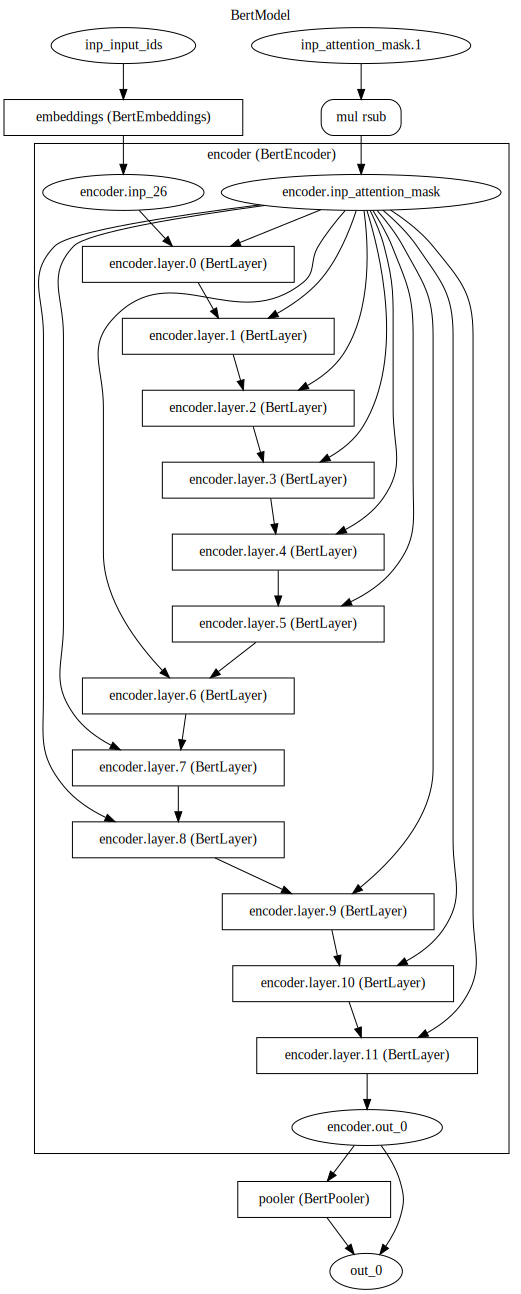

In [6]:
d = make_graph(traced_model, classes_to_visit={'BertEncoder'})
d.render('bert_model')
d

aten::matmul %attention_scores.1 : Float(1:2352, 12:196, 14:14, 14:1) = aten::matmul(%query_layer.1, %75), scope: __module.encoder/__module.encoder.layer.0/__module.encoder.layer.0.attention/__module.encoder.layer.0.attention.self # /usr/local/lib/python3.8/dist-packages/transformers/modeling_bert.py:236:0

aten::div %attention_scores.2 : Float(1:2352, 12:196, 14:14, 14:1) = aten::div(%attention_scores.1, %77), scope: __module.encoder/__module.encoder.layer.0/__module.encoder.layer.0.attention/__module.encoder.layer.0.attention.self # /usr/local/lib/python3.8/dist-packages/transformers/modeling_bert.py:237:0

aten::add %input.6 : Float(1:2352, 12:196, 14:14, 14:1) = aten::add(%attention_scores.2, %attention_mask, %79), scope: __module.encoder/__module.encoder.layer.0/__module.encoder.layer.0.attention/__module.encoder.layer.0.attention.self # /usr/local/lib/python3.8/dist-packages/transformers/modeling_bert.py:240:0

aten::softmax %input.7 : Float(1:2352, 12:196, 14:14, 14:1) = aten::s

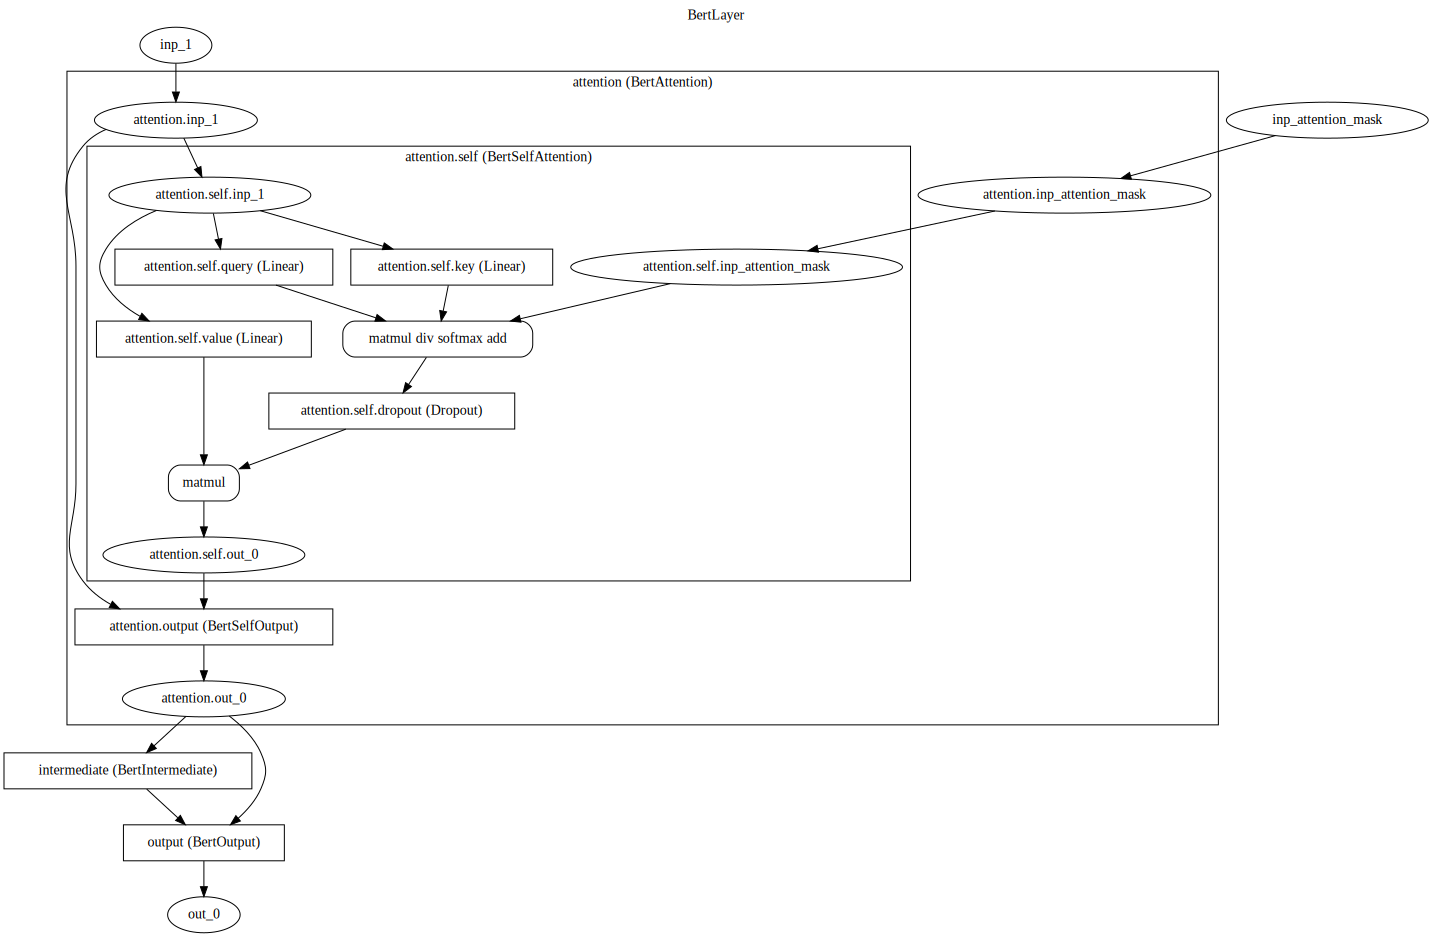

In [7]:
mod = getattr(traced_model.encoder.layer, "0") # traced_model.encoder.layer[0]
d = make_graph(getattr(traced_model.encoder.layer, "0"), classes_to_visit={'BertAttention', 'BertSelfAttention'})
d.render('bert_layer')
d

In [8]:
import torchvision

In [9]:
m = torchvision.models.resnet18()
tm = torch.jit.trace(m, [torch.randn(1, 3, 224, 224)])

In [10]:
m = torchvision.models.resnet18()
m.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
print(inspect.getsource(m.layer1[0].forward))

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



aten::add_ %input.10 : Float(1:200704, 64:3136, 56:56, 56:1) = aten::add_(%19, %1, %12), scope: __module.layer1/__module.layer1.0 # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:69:0

aten::add_ %input.16 : Float(1:200704, 64:3136, 56:56, 56:1) = aten::add_(%19, %1, %12), scope: __module.layer1/__module.layer1.1 # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:69:0

aten::add_ %input.23 : Float(1:100352, 128:784, 28:28, 28:1) = aten::add_(%21, %22, %14), scope: __module.layer2/__module.layer2.0 # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:69:0

aten::add_ %input.29 : Float(1:100352, 128:784, 28:28, 28:1) = aten::add_(%19, %1, %12), scope: __module.layer2/__module.layer2.1 # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:69:0

aten::add_ %input.36 : Float(1:50176, 256:196, 14:14, 14:1) = aten::add_(%21, %22, %14), scope: __module.layer3/__module.layer3.0 # /usr/local/lib/python3.8/dist-packages/torc

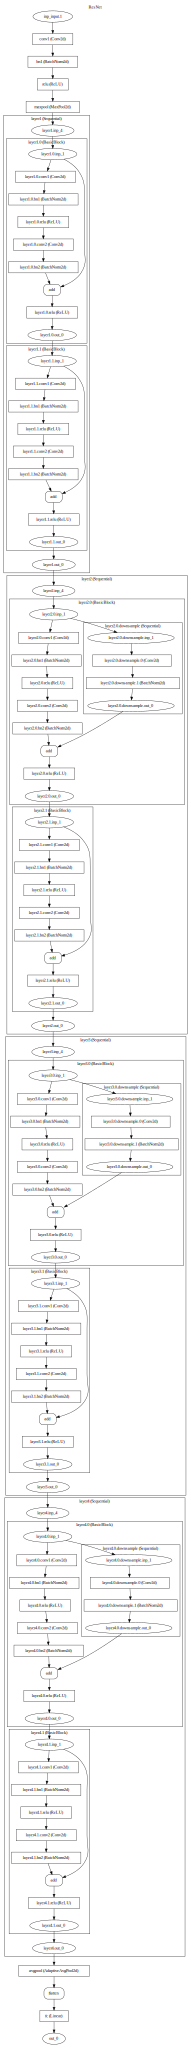

In [12]:
d = make_graph(tm)
d.render("resnet18_full")
d

aten::flatten %input : Float(1:512, 512:1) = aten::flatten(%1536, %1182, %1183) # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:214:0



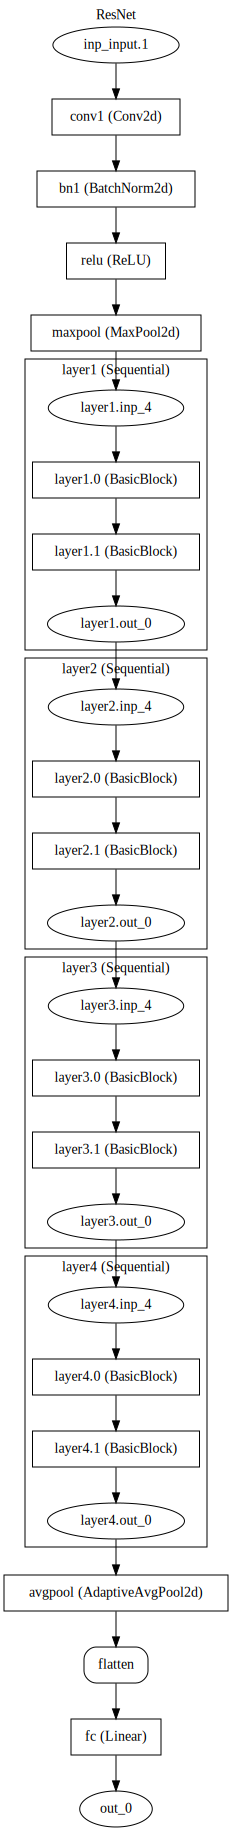

In [13]:
d = make_graph(tm, classes_to_visit={'Sequential'})
d.render("resnet18_highlevel")
d

aten::add_ %input.10 : Float(1:200704, 64:3136, 56:56, 56:1) = aten::add_(%19, %1, %12), scope: __module.layer1/__module.layer1.0 # /usr/local/lib/python3.8/dist-packages/torchvision/models/resnet.py:69:0



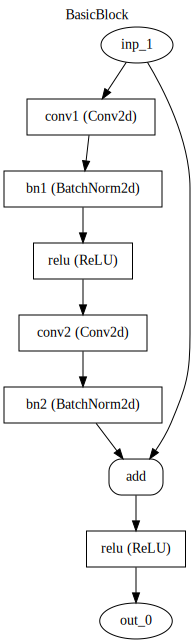

In [14]:
d = make_graph(getattr(tm.layer1, "0"))
d.render("resnet18_basicblock")
d

aten::upsample_bilinear2d %3096 : Float(1:1053696, 21:50176, 224:224, 224:1) = aten::upsample_bilinear2d(%3955, %3092, %3093, %3094, %3095) # /usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3163:0

prim::DictConstruct %3098 : Dict(str, Tensor) = prim::DictConstruct(%3097, %3096)



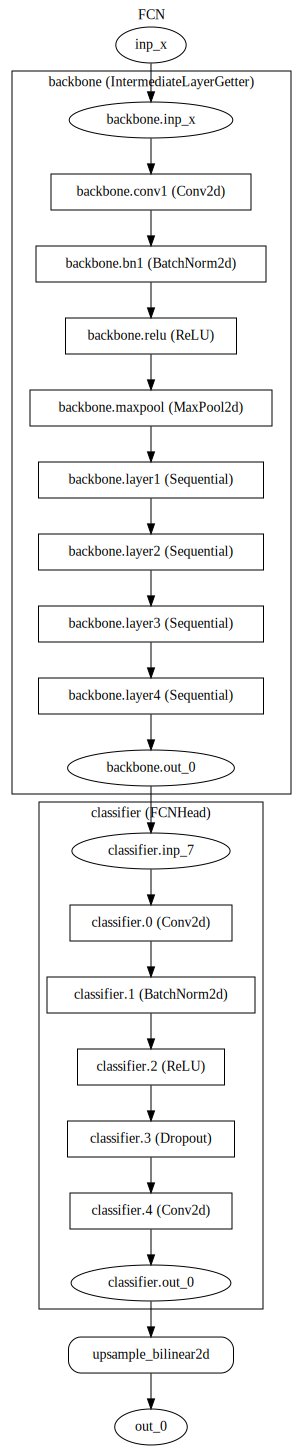

In [15]:
m = torchvision.models.segmentation.fcn_resnet50()
tm = torch.jit.trace(m, [torch.randn(1, 3, 224, 224)], strict=False)
d = make_graph(tm, classes_to_visit={'IntermediateLayerGetter', 'FCNHead'})
d.render("segmentation_fcn_high_level")
d

In [16]:
class Detection(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.m = torchvision.models.detection.fasterrcnn_resnet50_fpn().eval()
    def forward(self, inp):
        assert inp.shape[0] == 1
        res, = self.m(inp)
        return res['boxes'], res['labels'], res['scores']

tm = torch.jit.trace(Detection(), [torch.randn(1, 3, 224, 224)], check_trace=False)


<ipython-input-16-67b9b1140065>:6: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert inp.shape[0] == 1
/usr/local/lib/python3.8/dist-packages/torch/tensor.py:457: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish t

aten::div %ratio_height : Float() = aten::div(%52, %60), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/transform.py:269:0

aten::div %ratio_width : Float() = aten::div(%69, %77), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/transform.py:269:0

aten::mul %xmin : Float(0:1) = aten::mul(%xmin.1, %ratio_width), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/transform.py:276:0

aten::mul %xmax : Float(0:1) = aten::mul(%xmax.1, %ratio_width), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/transform.py:277:0

aten::mul %ymin : Float(0:1) = aten::mul(%ymin.1, %ratio_height), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/transform.py:278:0

aten::mul %ymax : Float(0:1) = aten::mul(%ymax.1, %ratio_height), scope: __module.m # /usr/local/lib/python3.8/dist-packages/torchvision/models/detecti

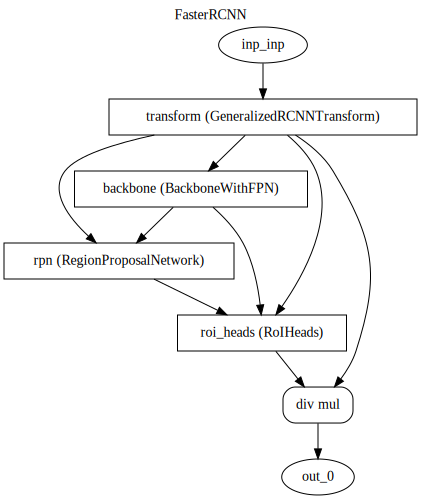

In [17]:
d = make_graph(tm.m, classes_to_visit={})
d.render('fasterrcnn.highlevel')
d

aten::flatten %objectness.1 : Float(159882:1, 1:1) = aten::flatten(%434, %435, %436), scope: __module.m/__module.m.rpn # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/rpn.py:248:0

aten::sub %widths.1 : Float(159882:1) = aten::sub(%472, %480, %481), scope: __module.m/__module.m.rpn # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/_utils.py:192:0

aten::sub %heights.1 : Float(159882:1) = aten::sub(%490, %498, %499), scope: __module.m/__module.m.rpn # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/_utils.py:193:0

aten::mul %510 : Float(159882:1) = aten::mul(%widths.1, %509), scope: __module.m/__module.m.rpn # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/_utils.py:194:0

aten::add %ctr_x.1 : Float(159882:1) = aten::add(%508, %510, %511), scope: __module.m/__module.m.rpn # /usr/local/lib/python3.8/dist-packages/torchvision/models/detection/_utils.py:194:0

aten::mul %522 : Float(159882:1) = aten::mul(%h

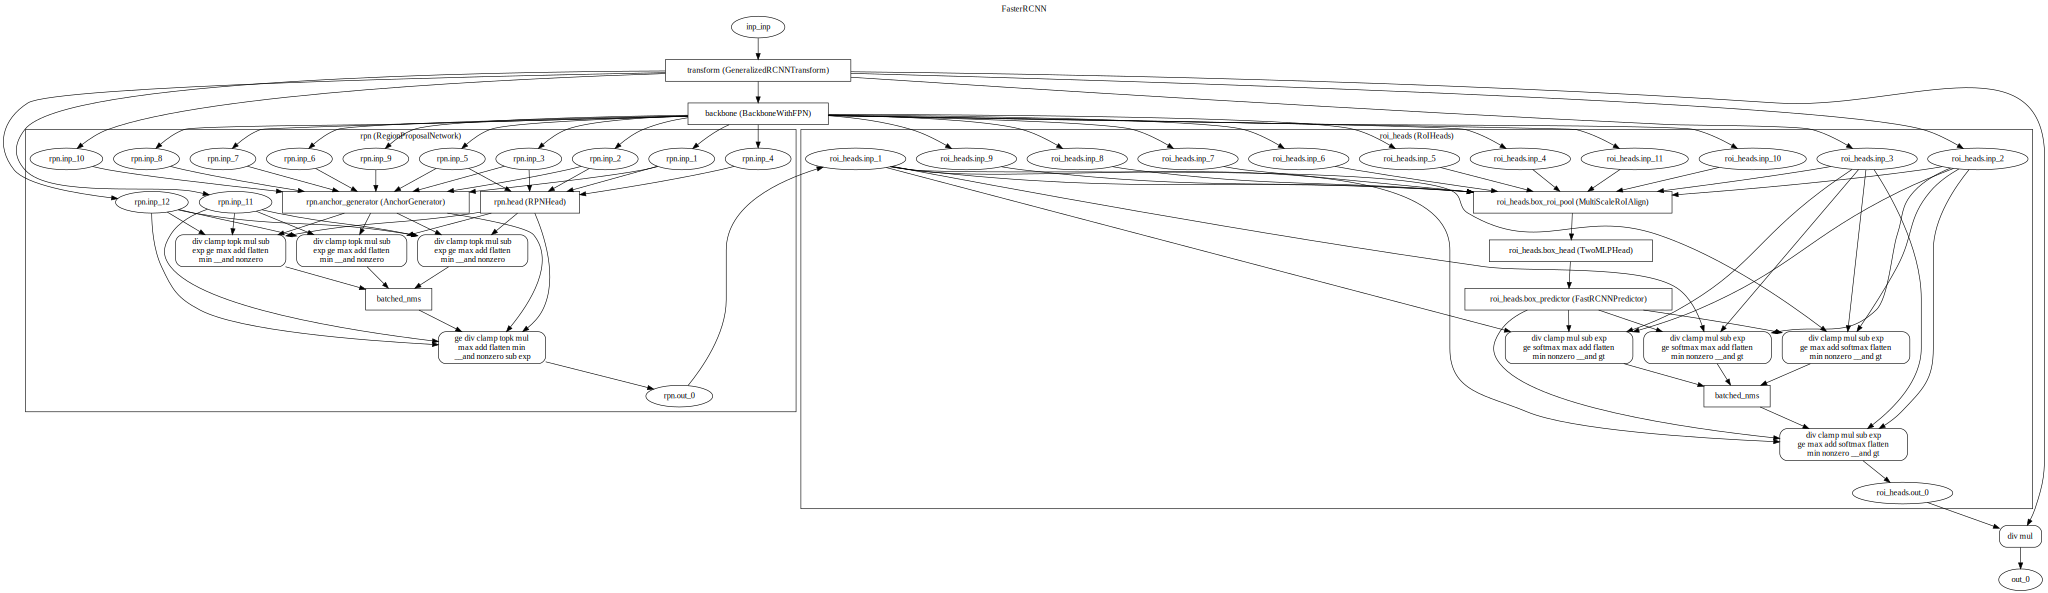

In [18]:
d = make_graph(tm.m, classes_to_visit={'RegionProposalNetwork', 'RoIHeads'})
d.render("fasterrcnn.detail")
d